In [1]:
# 训练误差（training error）
# 指模型在训练数据集上表现出的误差
# 泛化误差（generalization error）
# 模型在任意一个测试数据样本上表现出的误差的期望，通过测试数据集上的误差来近似
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [27]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1)) # 200*1
# 正常默认是按行连结，但是这边可能因为都是200*1，所以默认使用列连结？
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
# 按公式计算
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
         + true_w[2] *poly_features[:, 2] + true_b)
# 添加噪声
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [28]:
features[:2],poly_features[:2],labels[:2]

(
 [[ 1.5796887 ]
  [-0.94254106]]
 <NDArray 2x1 @cpu(0)>,
 
 [[ 1.5796887   2.4954164   3.9419808 ]
  [-0.94254106  0.8883836  -0.8373381 ]]
 <NDArray 2x3 @cpu(0)>,
 
 [20.46375  -3.849371]
 <NDArray 2 @cpu(0)>)

In [29]:
# 本函数已保存在d2lzh包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [30]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
          '\nbias:', net[0].bias.data().asnumpy())

final epoch: train loss 0.0062641543 test loss 0.0061083506
weight: [[ 1.1467779 -3.39227    5.6121726]] 
bias: [4.9911427]


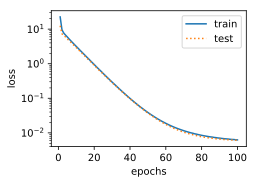

In [31]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

final epoch: train loss 68.96219 test loss 41.855213
weight: [[17.769344]] 
bias: [2.7423058]


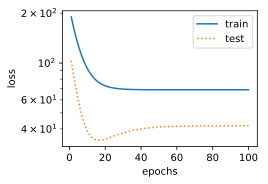

In [33]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:]) # 线性函数，欠拟合

final epoch: train loss 0.05402135 test loss 19.066544
weight: [[1.8834716 1.3878874 3.5364146]] 
bias: [0.11774448]


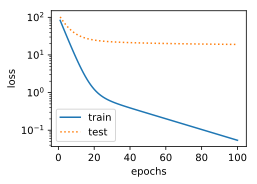

In [34]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:]) # 训练样本不足，过拟合：模型的训练误差远小于它在测试数据集上的误差。